#RESULTADOS SUPERESCALAR

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker 
from matplotlib.lines import Line2D
import seaborn as sns

In [61]:
dfD = pd.read_csv("INFO/BENCH/TORVS/dhrystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=50)
dfR = pd.read_csv("INFO/BENCH/TORVS/raystones.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=50)
dfC = pd.read_csv("INFO/BENCH/TORVS/coremark.csv", usecols=["CPU", "CPI", "INSTRET"], nrows=50)
df0 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "ALMs"], nrows=50)
df2 = pd.read_csv("INFO/BOARDS/DE10S/dhrystones.csv", usecols=["CPU", "FMAX1"], nrows=50)
# Compute average CPI and INSTRET across dfD, dfR, and dfC
df_avg = dfD[["CPU"]].copy()
df_avg["CPI"] = (dfD["CPI"] + dfR["CPI"] + dfC["CPI"]) / 3
df_avg["INSTRET"] = (dfD["INSTRET"] + dfR["INSTRET"] + dfC["INSTRET"]) / 3

# Calculate CPU_TIME (CPI * INSTRET) / (FMAX1 * 10^6)
df_avg = df_avg.merge(df2[["CPU", "FMAX1"]], on="CPU", how="left")  # Ensure proper alignment
df_avg["CPU_TIME"] = (df_avg["CPI"] * df_avg["INSTRET"]) / (df_avg["FMAX1"] * 1e6)

#print("df_avg CPUs:", df_avg["CPU"].unique())
#print("df2 CPUs:", df2["CPU"].unique())
#print("Missing CPUs in df_avg:", set(df2["CPU"]) - set(df_avg["CPU"]))
#print(df_avg.isnull().sum())  # Look for missing FMAX1 values

# Function to identify Pareto frontier (minimizing both dimensions)
def identify_pareto(data):
    """Identify Pareto frontier points for minimization."""
    pareto = np.ones(data.shape[0], dtype=bool)  # Start with all points as True
    for i, point in enumerate(data):
        if pareto[i]:  # Only evaluate points not already dominated
            # Check if there is any point that is strictly better in both dimensions
            for j, other_point in enumerate(data):
                if (other_point[0] < point[0] and other_point[1] < point[1]):
                    pareto[i] = False
                    break  # No need to check further if point i is dominated
    return data[pareto]

def plot_graph_pareto(united, torvs):
    # Merge dataframes to include ALMs and CPU_TIME
    data = pd.merge(df0, df_avg[["CPU", "CPU_TIME"]], on="CPU", how="inner")
    # Filter rows where CPU starts with "torvs8p"
    if united :
        data = data[data["CPU"].str.startswith(torvs)]
    else:
        data = data[data["CPU"].str.endswith(torvs)]
    # Extract values for ALMs and CPU_TIME
    points = data[["ALMs", "CPU_TIME"]].values
    pareto_front = identify_pareto(points)    
    
    plt.figure(figsize=(12, 8))
    plt.scatter(points[:, 0], points[:, 1], label="All Points", color="blue")
    plt.scatter(pareto_front[:, 0], pareto_front[:, 1], label="Pareto Frontier", color="red")
    plt.plot(pareto_front[:, 0], pareto_front[:, 1], linestyle="--", color="red")
    
    # Add labels for points
    for i in range(len(data)):
        plt.text(points[i, 0], points[i, 1], data["CPU"].iloc[i], fontsize=10, ha="right", va="bottom")
    
    plt.xlabel("ALMs")
    plt.ylabel("CPU_TIME")
    plt.title("Pareto Frontier (ALMs vs CPU_TIME)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_graph_time(united, torvs, df2):

    # Merge dataframes to include ALMs, CPI, CPU_TIME, and FMAX1
    df2 = pd.merge(df2, df_avg[["CPU", "CPU_TIME", "CPI"]], on="CPU", how="inner")
    data = pd.merge(df0, df2[["CPU", "CPU_TIME", "FMAX1", "CPI"]], on="CPU", how="inner")
    
    # Filter rows where CPU starts with "torvs8p"
    if united :
        data = data[data["CPU"].str.startswith(torvs)]
    else:
        data = data[data["CPU"].str.endswith(torvs)]
    # Sort the data by CPU for proper line plotting
    data_sorted = data.sort_values(by="CPU")
    # Calculate percentage changes in CPI, FMAX1, and CPU_TIME
    data_sorted["CPI_change_pct"] = data_sorted["CPI"].pct_change().fillna(0) * 100
    data_sorted["FMAX1_change_pct"] = data_sorted["FMAX1"].pct_change().fillna(0) * 100
    
    # Modify the CPU_TIME change to make the negative percentage positive when decreasing
    data_sorted["CPU_TIME_change_pct"] = data_sorted["CPU_TIME"].pct_change().fillna(0) * 100
    data_sorted["CPU_TIME_change_pct"] = np.abs(data_sorted["CPU_TIME_change_pct"])
    
    # Adjust the CPI change to consider a decrease as a positive gain
    data_sorted["CPI_change_pct"] = np.abs(data_sorted["CPI_change_pct"])   
    
    # Plot the graph
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Plot CPU_TIME vs CPU (primary Y-axis)
    ax1.plot(data_sorted["CPU"], data_sorted["CPU_TIME"], label="CPU_TIME", color="blue", marker='o')
    ax1.set_xlabel("CPU")
    #ax1.set_ylabel("Time", color="blue")  # Changed label to "Time"
    ax1.tick_params(axis='y', labelcolor="blue")
    
    # Annotate the percentage changes in CPI (green), FMAX1 (red), and CPU_TIME (blue) at each point
    for i, row in data_sorted.iterrows():
        ax1.annotate(f'CPI Change: {row["CPI_change_pct"]:.2f}%', 
                     (row["CPU"], row["CPU_TIME"]), 
                     textcoords="offset points", 
                     xytext=(0, 5), 
                     ha='center', fontsize=9, color='green')  # CPI Change in Green
        
        ax1.annotate(f'FMAX1 Change: {row["FMAX1_change_pct"]:.2f}%', 
                     (row["CPU"], row["CPU_TIME"]), 
                     textcoords="offset points", 
                     xytext=(0, -15), 
                     ha='center', fontsize=9, color='red')  # FMAX1 Change in Red
        
        ax1.annotate(f'Time Change: {row["CPU_TIME_change_pct"]:.2f}%', 
                     (row["CPU"], row["CPU_TIME"]), 
                     textcoords="offset points", 
                     xytext=(0, -25), 
                     ha='center', fontsize=9, color='blue')  # CPU_TIME Change in Blue
    
    # Customize the plot
    plt.title("CPU_TIME vs CPU (with CPI, FMAX1, and Time Percentage Changes)")
    plt.grid(True)
    
    # Save the graph to an image (optional)
    fig.savefig("cpu_timeXcpu.png", format="png")
    
    # Show the plot
    plt.show()

def plot_graph_cpi(united, torvs, df2):
    # Merge dataframes to include ALMs and CPU_TIME
    df2 = df2.merge(df_avg[["CPU", "CPU_TIME", "CPI"]], on="CPU", how="left")
    #df2 = pd.merge(df2, df_avg[["CPU", "CPU_TIME", "CPI"]], on="CPU", how="inner")
    data = pd.merge(df0, df2[["CPU", "CPU_TIME", "CPI"]], on="CPU", how="inner")
    
    # Filter rows where CPU starts with "torvs8p"
    data = data[data["CPU"].str.startswith(torvs)] if united else data[data["CPU"].str.endswith(torvs)]
    #print(data[["CPU", "CPI"]])  # Check if the filtered CPUs are correct

    # Sort the data by CPU for proper line plotting
    data_sorted = data.sort_values(by="CPU")
    
    # Plot the graph
    fig, ax1 = plt.subplots(figsize=(11, 8))
    
    # Plot CPU_TIME vs CPU (primary Y-axis)
    ax1.plot(data_sorted["CPU"], data_sorted["CPU_TIME"], label="CPU_TIME", color="blue", marker='o')
    ax1.set_xlabel("CPU")
    ax1.set_ylabel("CPU_TIME", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    
    # Create a secondary Y-axis for CPI
    ax2 = ax1.twinx()
    ax2.plot(data_sorted["CPU"], data_sorted["CPI"], label="CPI", color="green", marker='x')
    ax2.set_ylabel("CPI", color="green")
    ax2.tick_params(axis='y', labelcolor="green")
    
    # Customize the plot
    plt.title("CPU_TIME vs CPU with CPI on the right")
    plt.grid(True)
    plt.show()

def plot_graph_fmax(united, torvs, df2):
    # Merge dataframes to include ALMs and CPU_TIME
    df2 = pd.merge(df2, df_avg[["CPU", "CPU_TIME", "CPI"]], on="CPU", how="inner")
    data = pd.merge(df0, df2[["CPU", "CPU_TIME", "FMAX1"]], on="CPU", how="inner")
    
    # Filter rows where CPU starts with "torvs8p"
    if united :
        data = data[data["CPU"].str.startswith(torvs)]
    else:
        data = data[data["CPU"].str.endswith(torvs)]
    
    # Sort the data by CPU for proper line plotting
    data_sorted = data.sort_values(by="CPU")
    
    # Plot the graph
    fig, ax1 = plt.subplots(figsize=(11, 6))
    
    # Plot CPU_TIME vs CPU (primary Y-axis)
    ax1.plot(data_sorted["CPU"], data_sorted["CPU_TIME"], label="CPU_TIME", color="blue", marker='o')
    ax1.set_xlabel("CPU")
    ax1.set_ylabel("CPU_TIME", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    
    # Create a secondary Y-axis for FMAX1
    ax2 = ax1.twinx()
    ax2.plot(data_sorted["CPU"], data_sorted["FMAX1"], label="FMAX1", color="red", marker='x')
    ax2.set_ylabel("FMAX1", color="red")
    ax2.tick_params(axis='y', labelcolor="red")
    
    # Customize the plot
    plt.title("CPU_TIME vs CPU with FMAX1 on the right")
    plt.grid(True)
    plt.show()

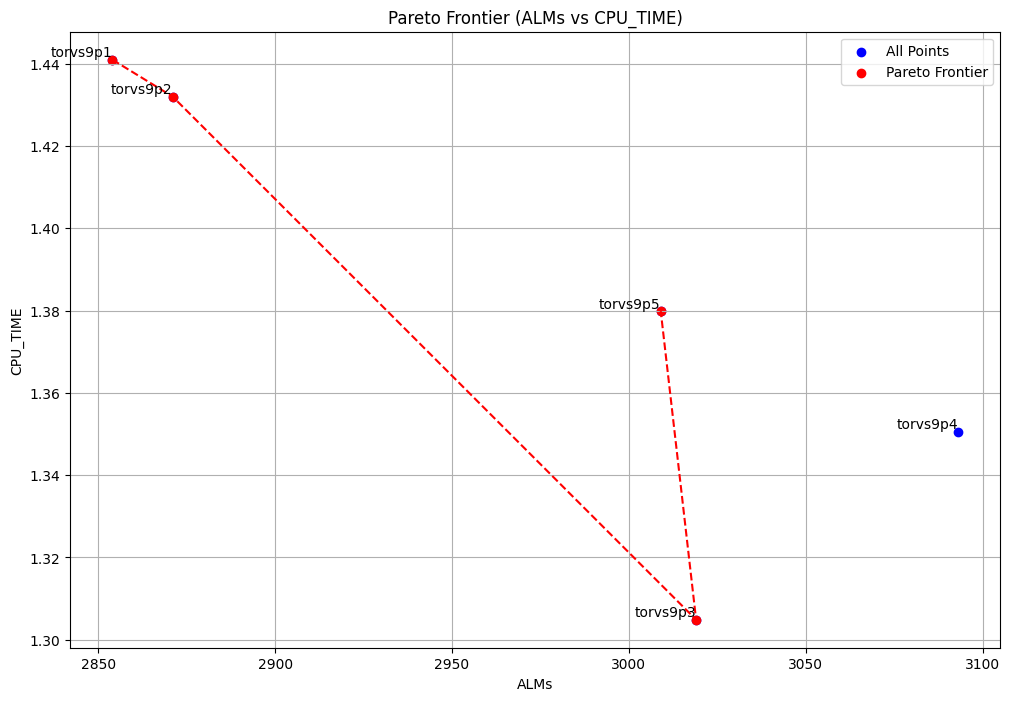

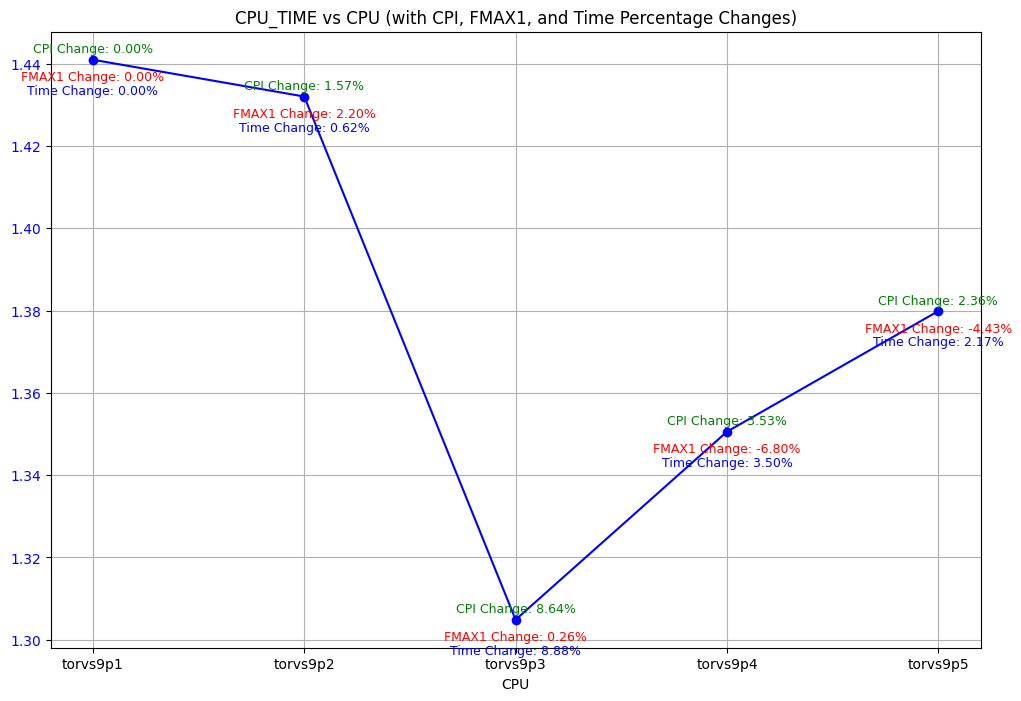

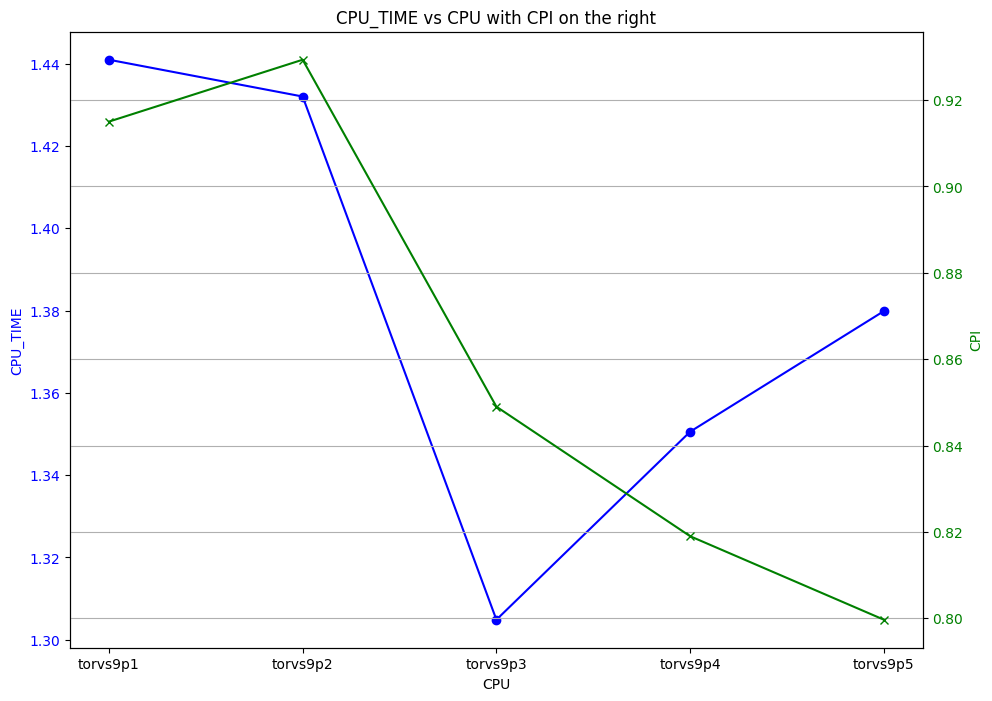

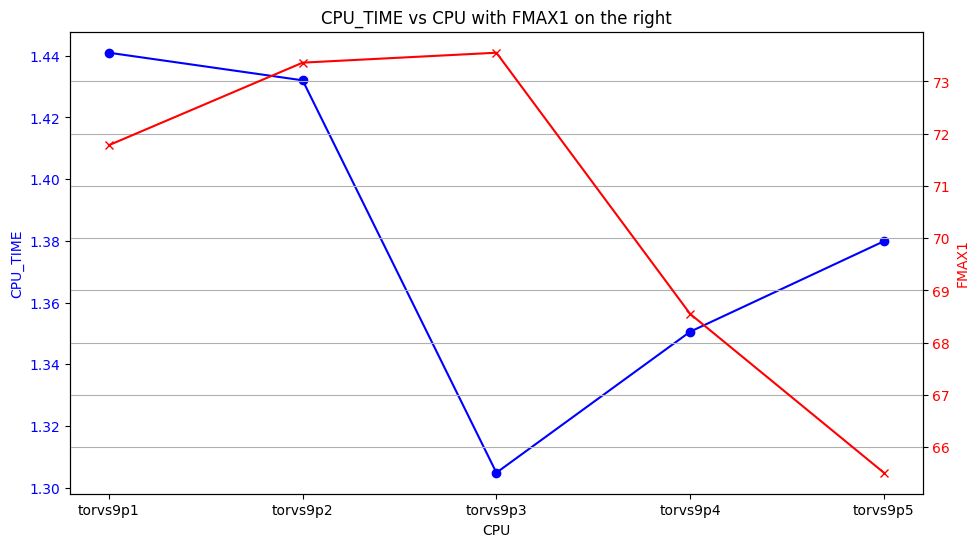

In [62]:
plot_graph_pareto(1,"torvs9p")
plot_graph_time(1,"torvs9p", df2)
plot_graph_cpi(1,"torvs9p", df2)
plot_graph_fmax(1,"torvs9p", df2)

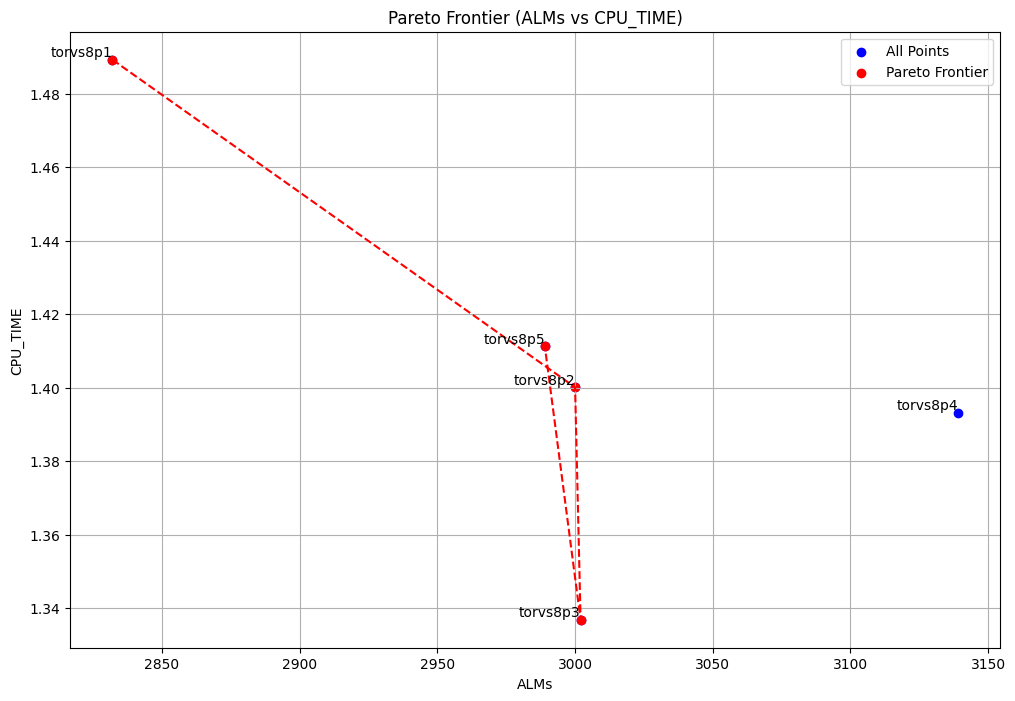

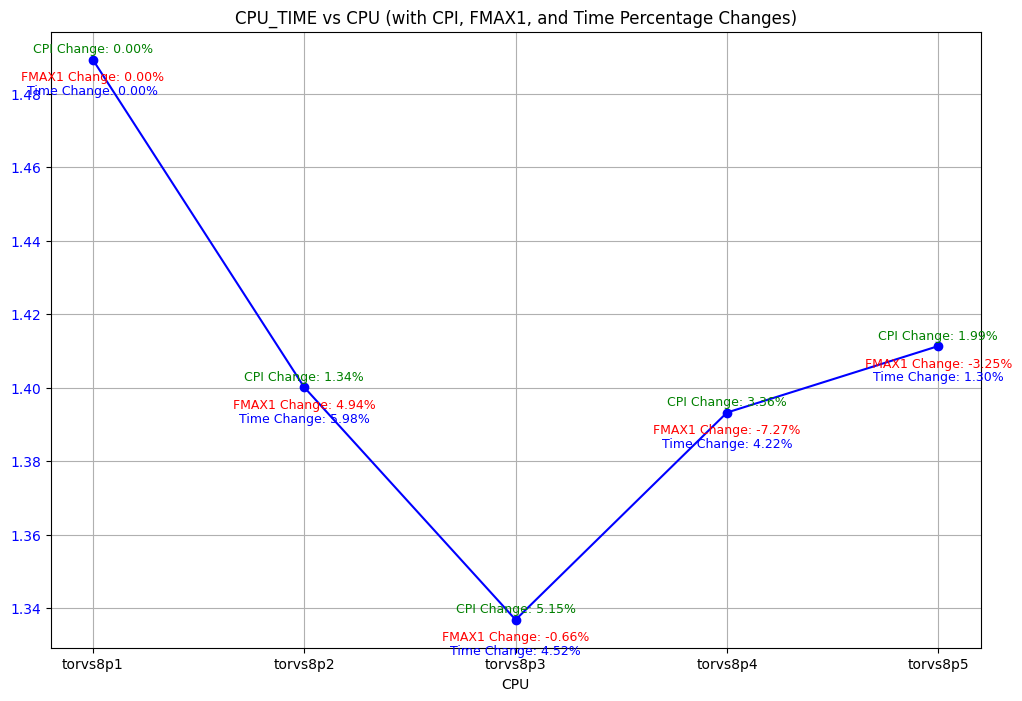

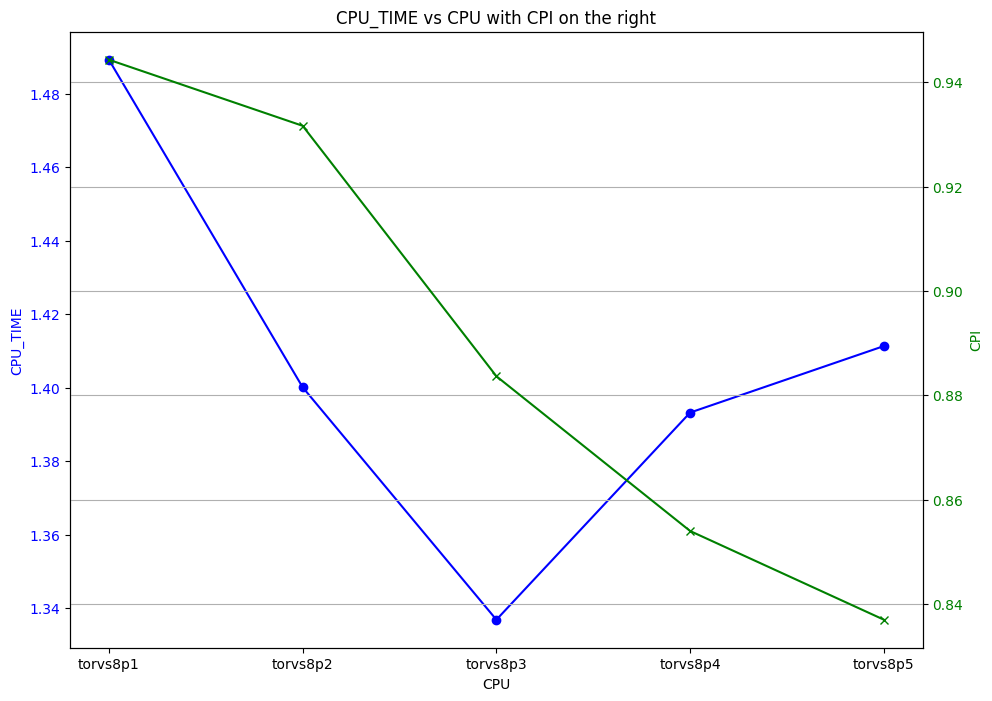

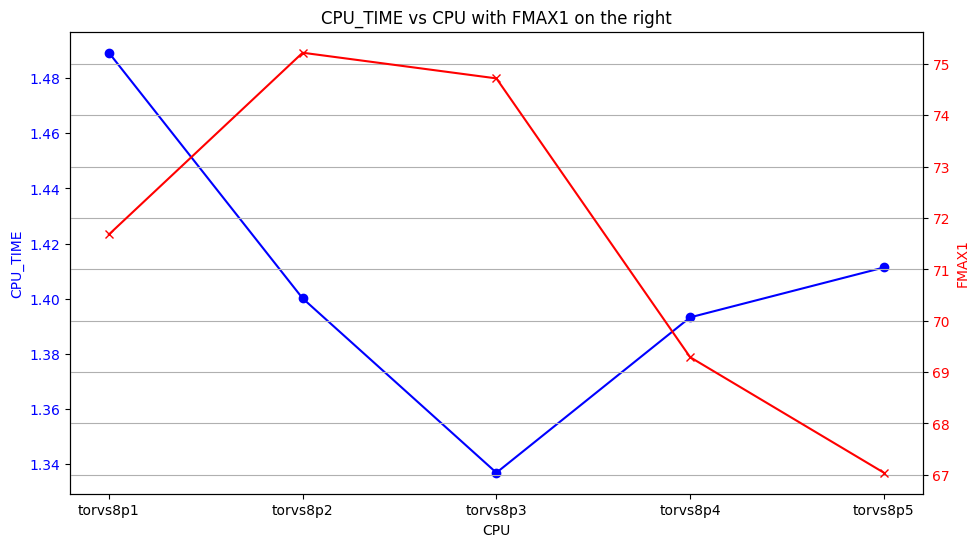

In [63]:
plot_graph_pareto(1,"torvs8p")
plot_graph_time(1,"torvs8p", df2)
plot_graph_cpi(1, "torvs8p", df2)
plot_graph_fmax(1, "torvs8p", df2)

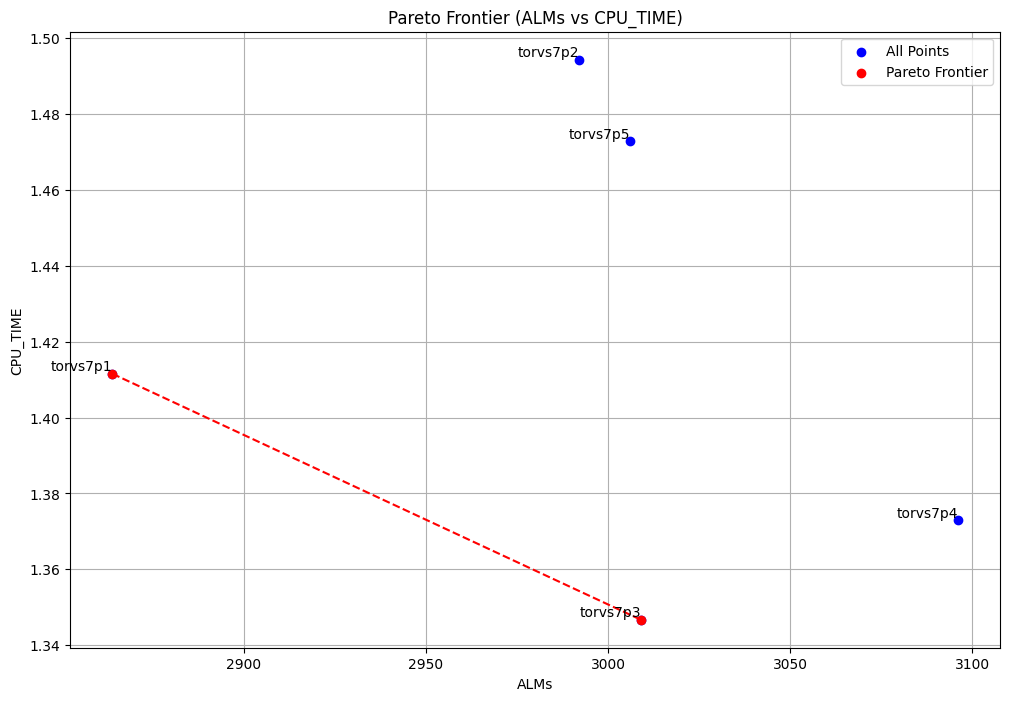

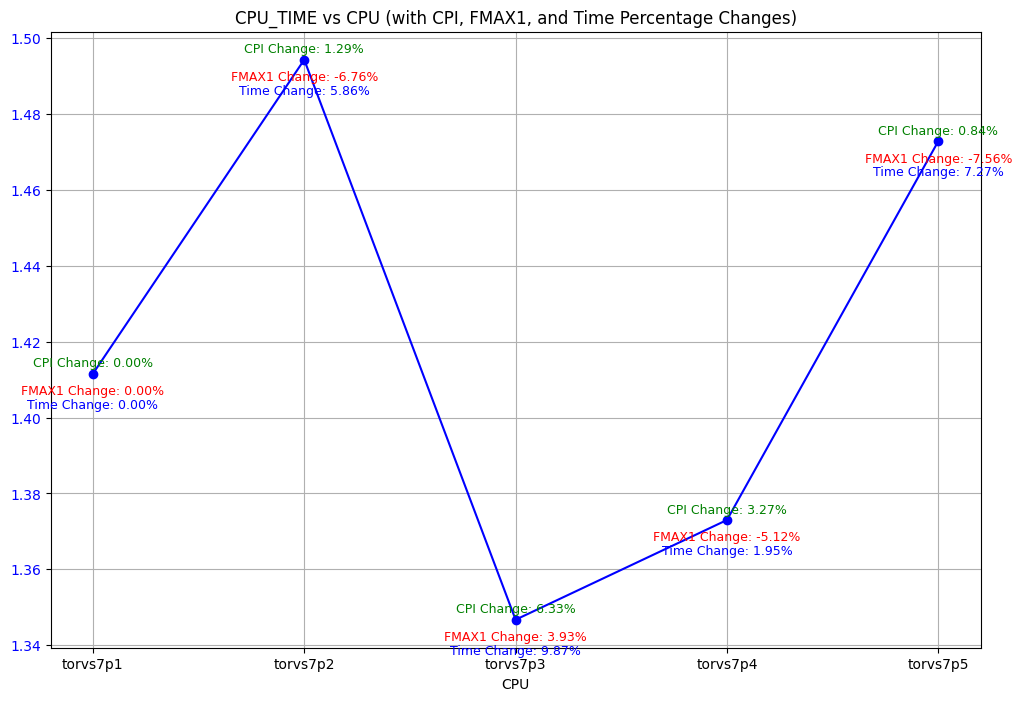

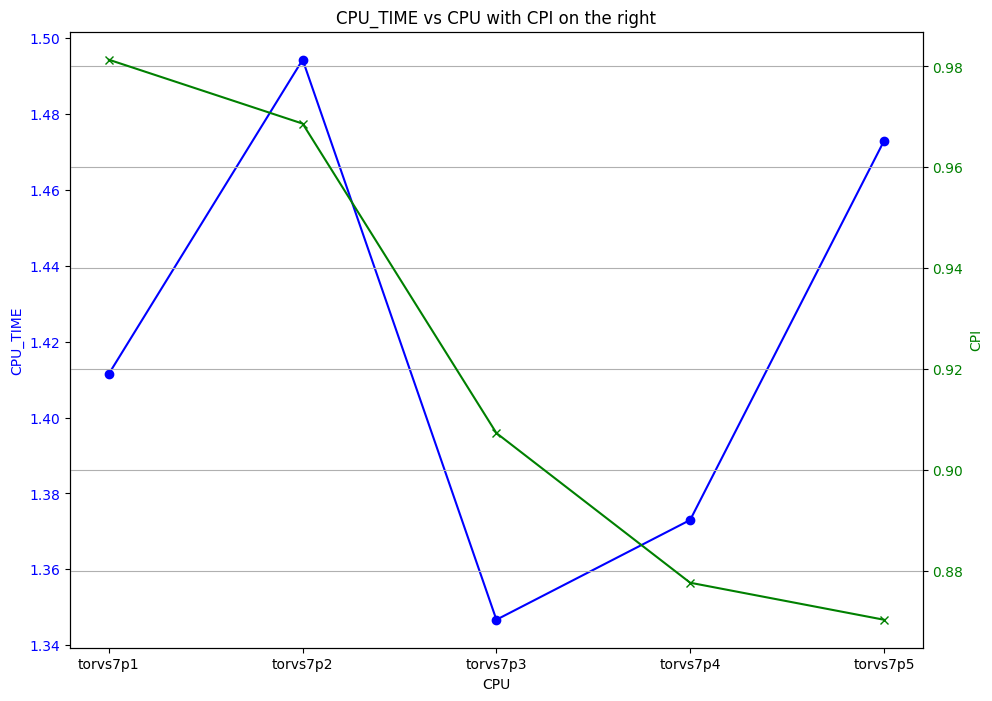

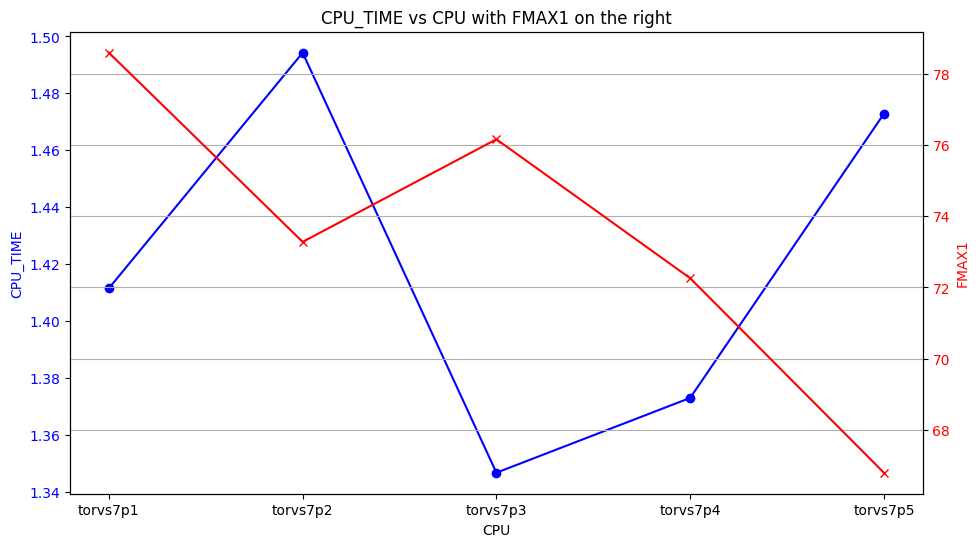

In [64]:
plot_graph_pareto(1,"torvs7p")
plot_graph_time(1,"torvs7p", df2)
plot_graph_cpi(1, "torvs7p", df2)
plot_graph_fmax(1, "torvs7p", df2)

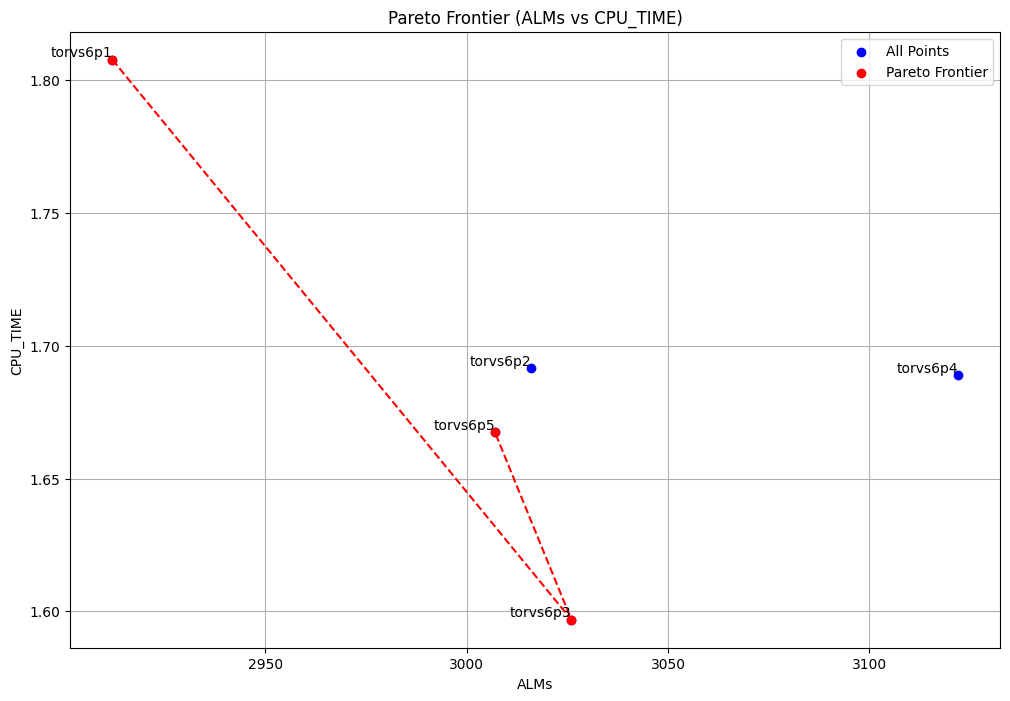

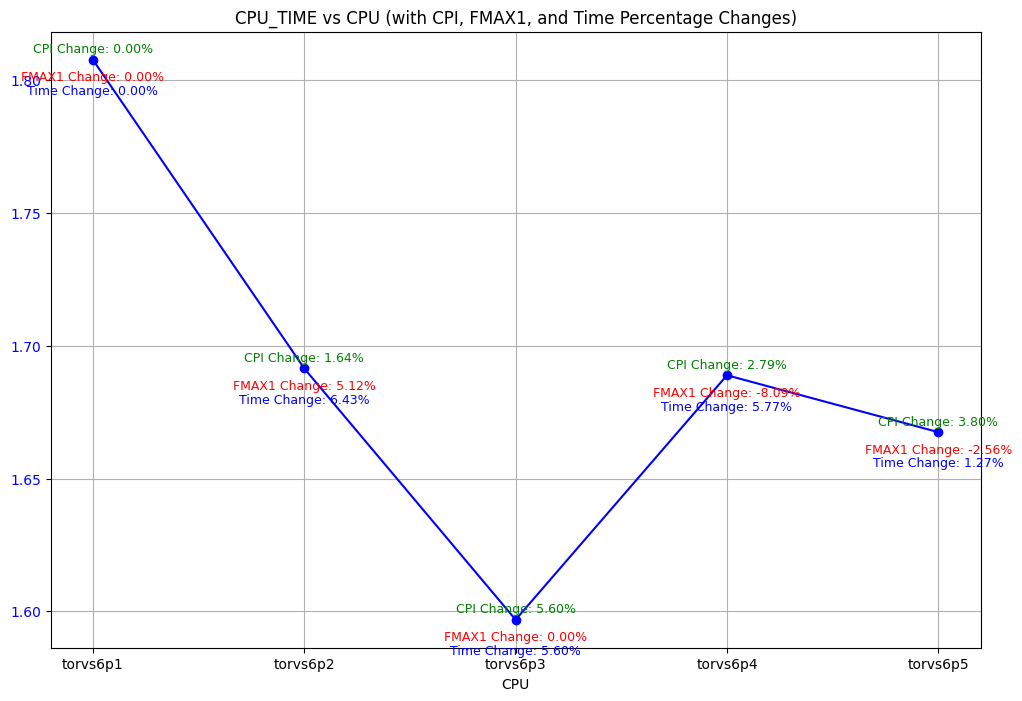

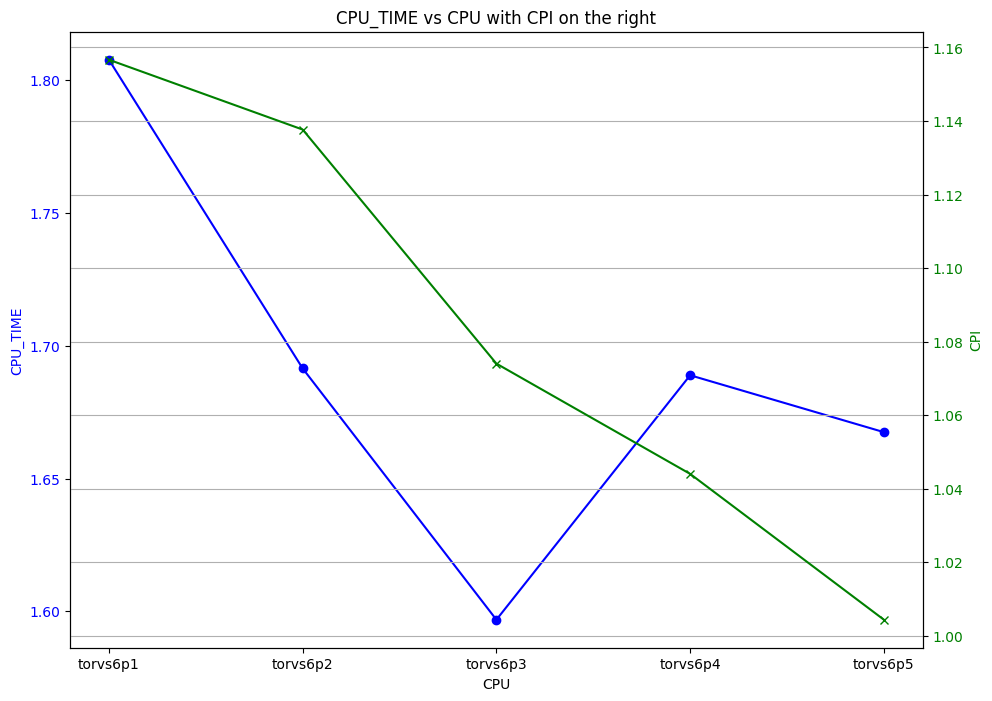

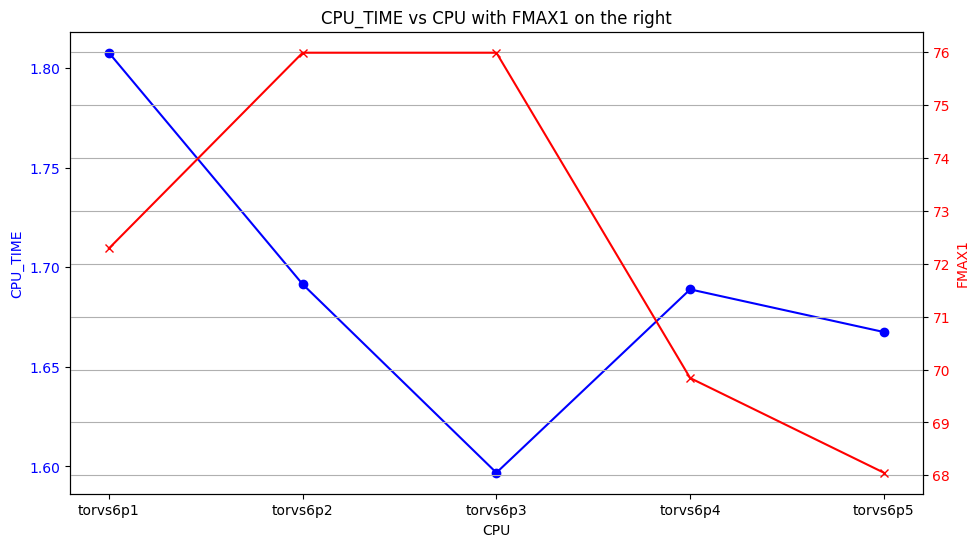

In [65]:
plot_graph_pareto(1,"torvs6p")
plot_graph_time(1,"torvs6p", df2)
plot_graph_cpi(1, "torvs6p", df2)
plot_graph_fmax(1, "torvs6p", df2)

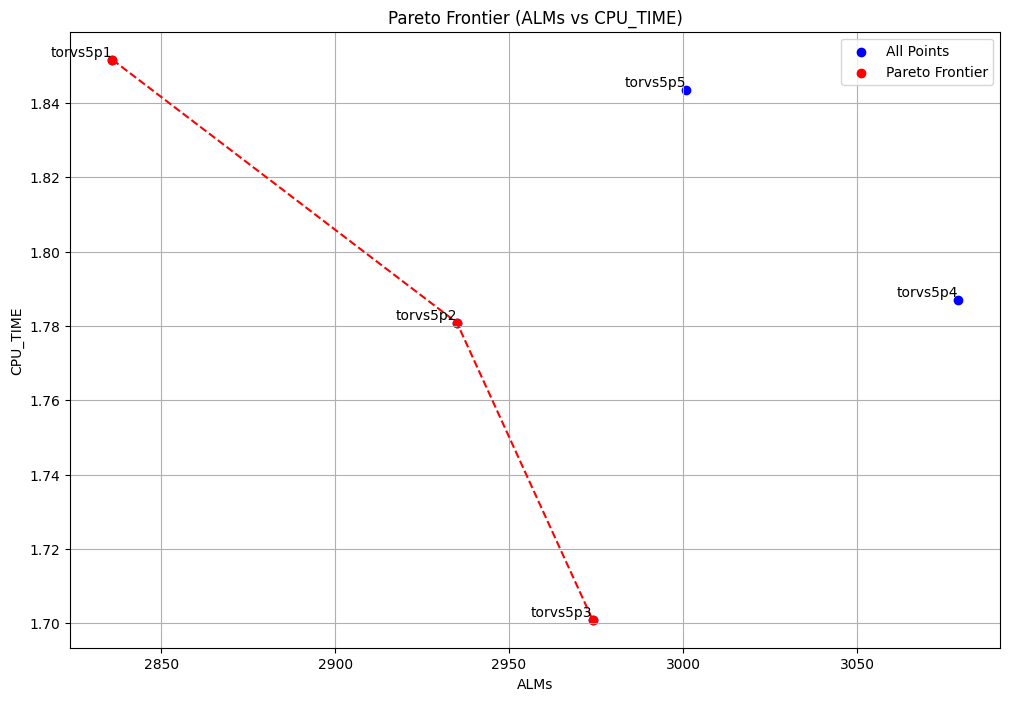

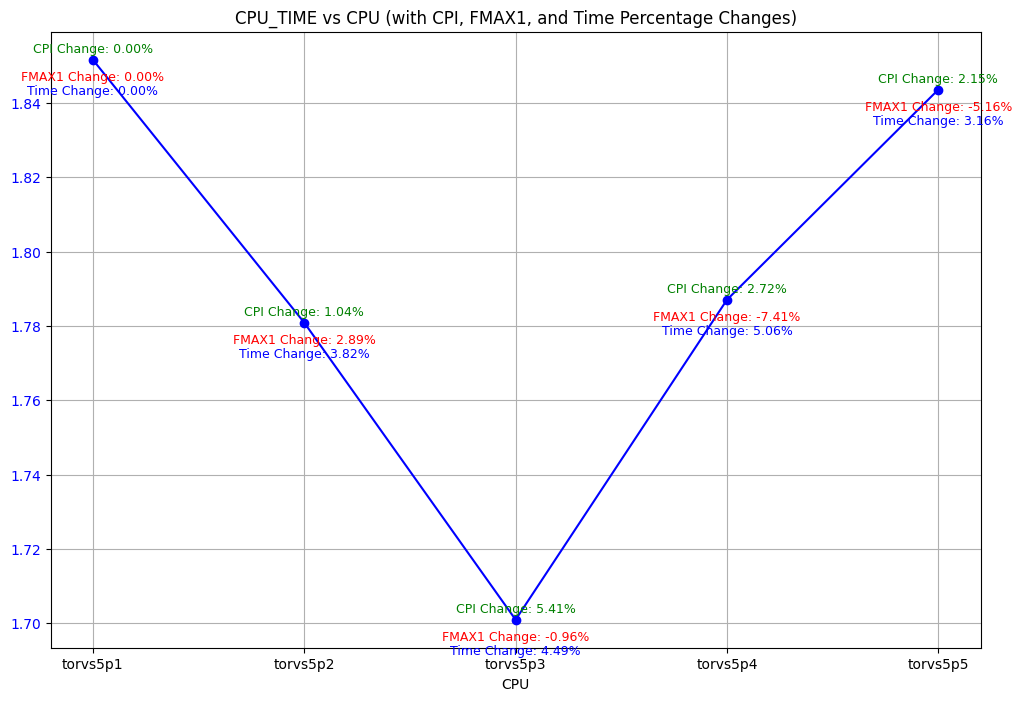

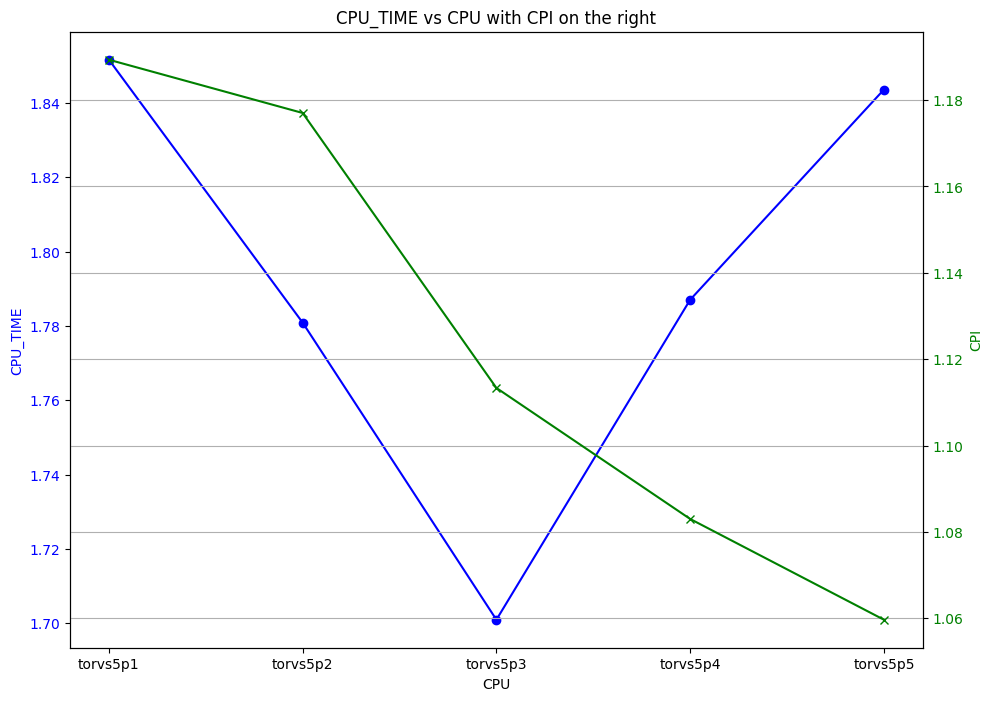

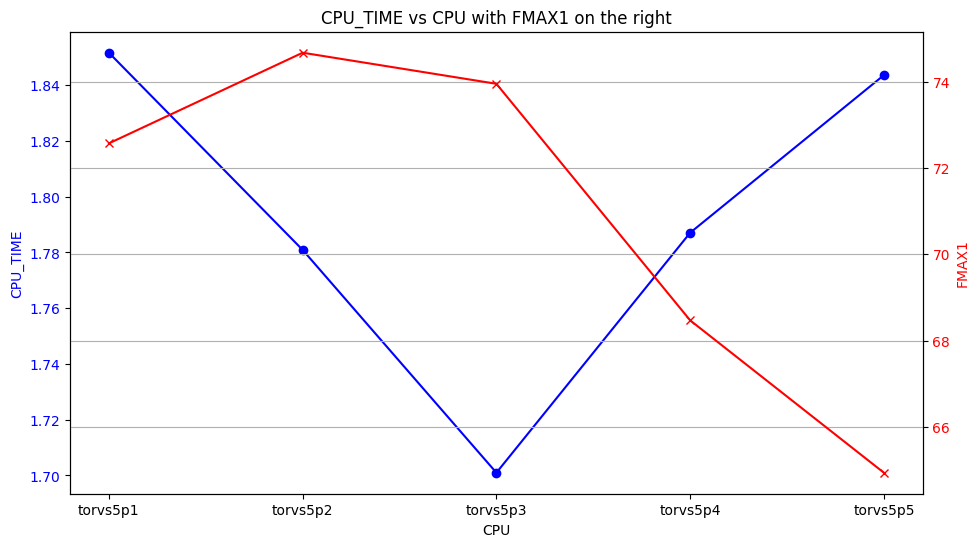

In [66]:
plot_graph_pareto(1,"torvs5p")
plot_graph_time(1,"torvs5p", df2)
plot_graph_cpi(1, "torvs5p", df2)
plot_graph_fmax(1, "torvs5p", df2)

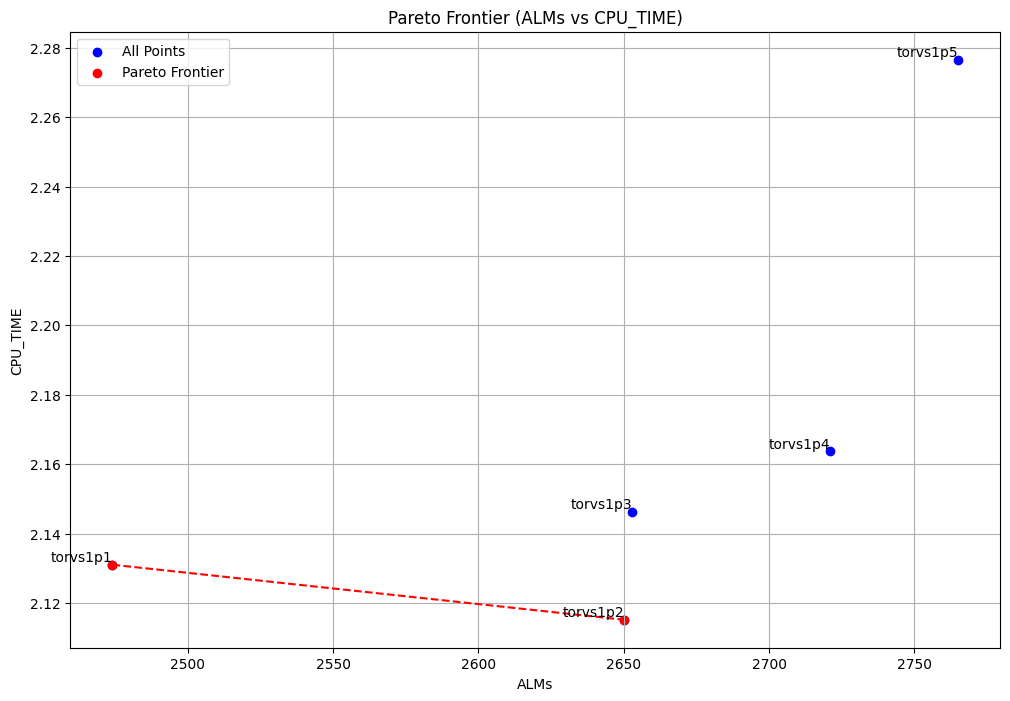

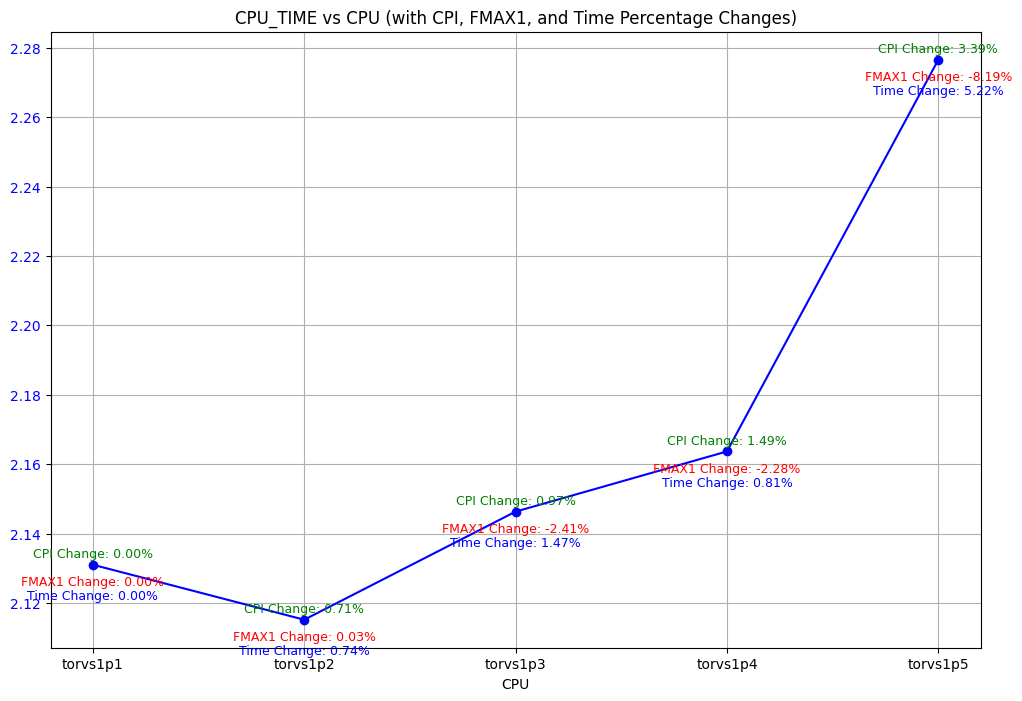

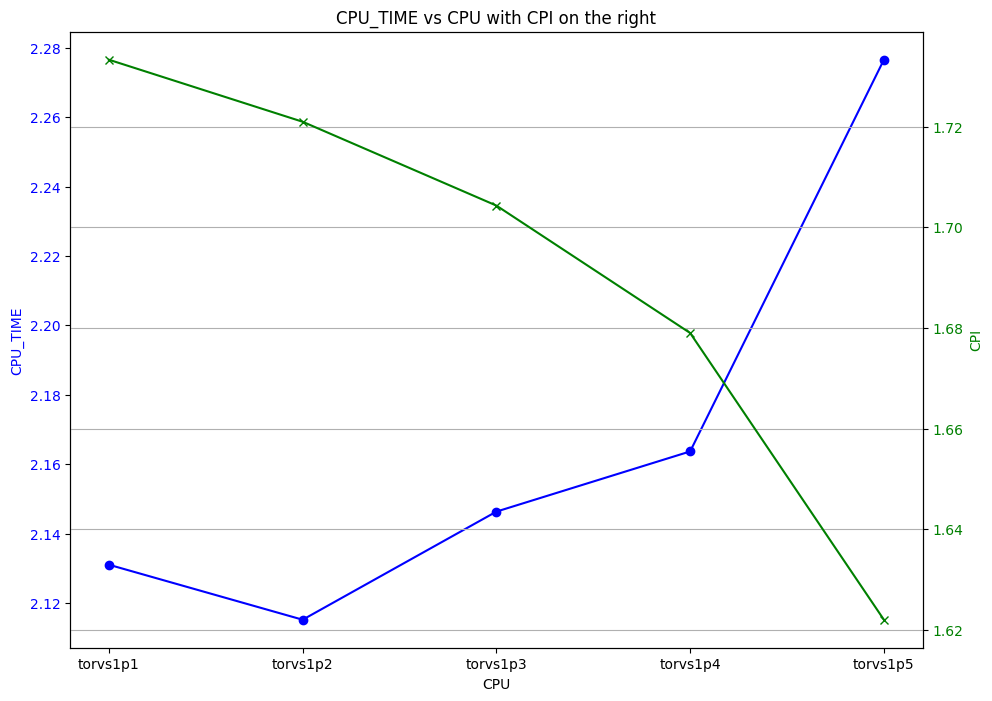

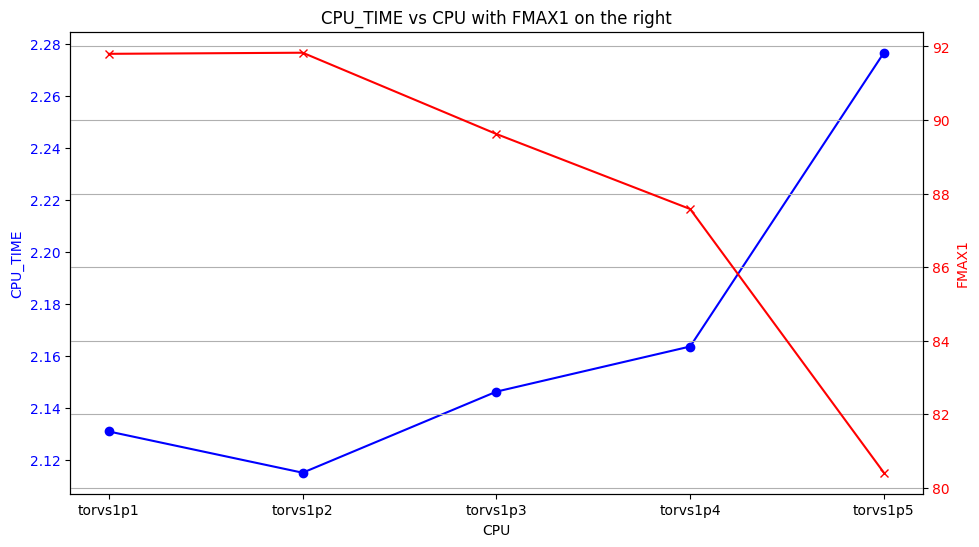

In [67]:
plot_graph_pareto(1,"torvs1p")
plot_graph_time(1,"torvs1p", df2)
plot_graph_cpi(1, "torvs1p", df2)
plot_graph_fmax(1, "torvs1p", df2)

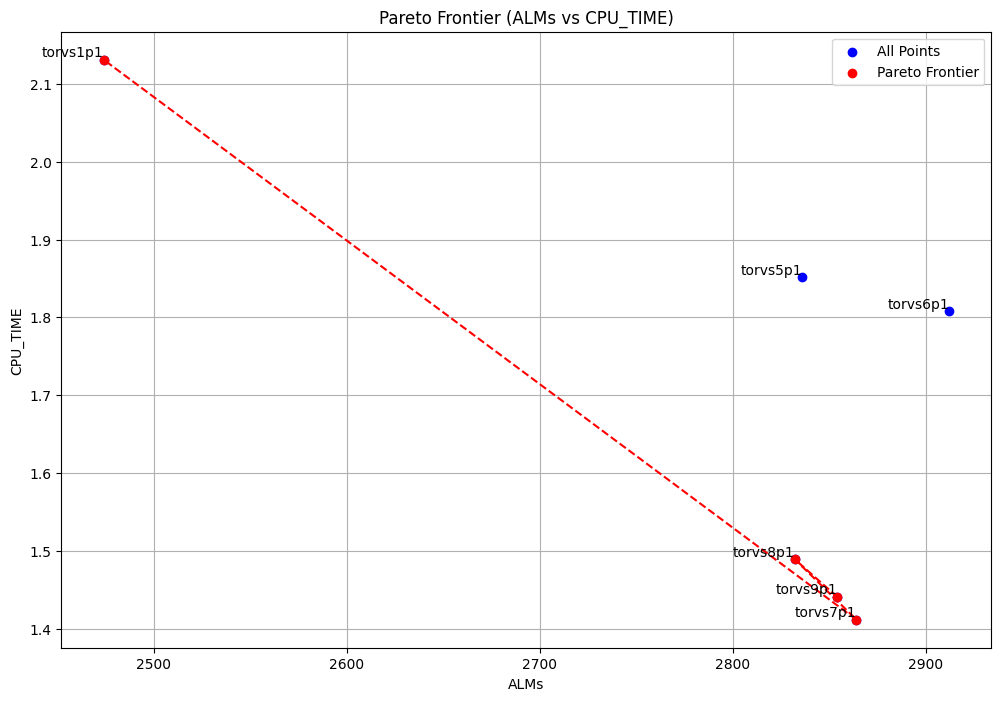

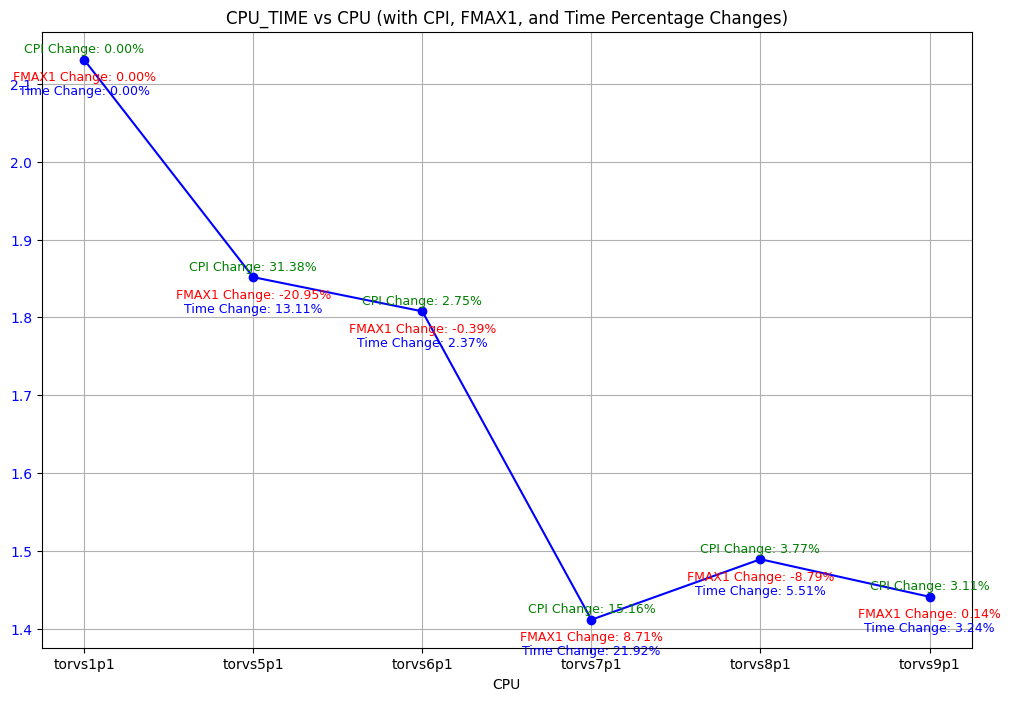

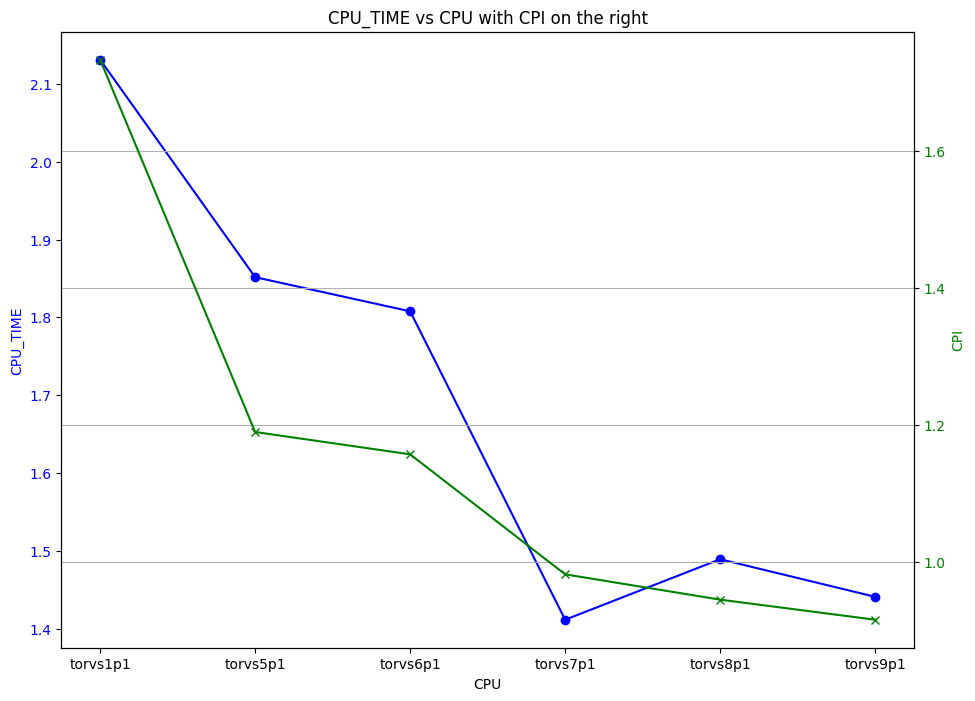

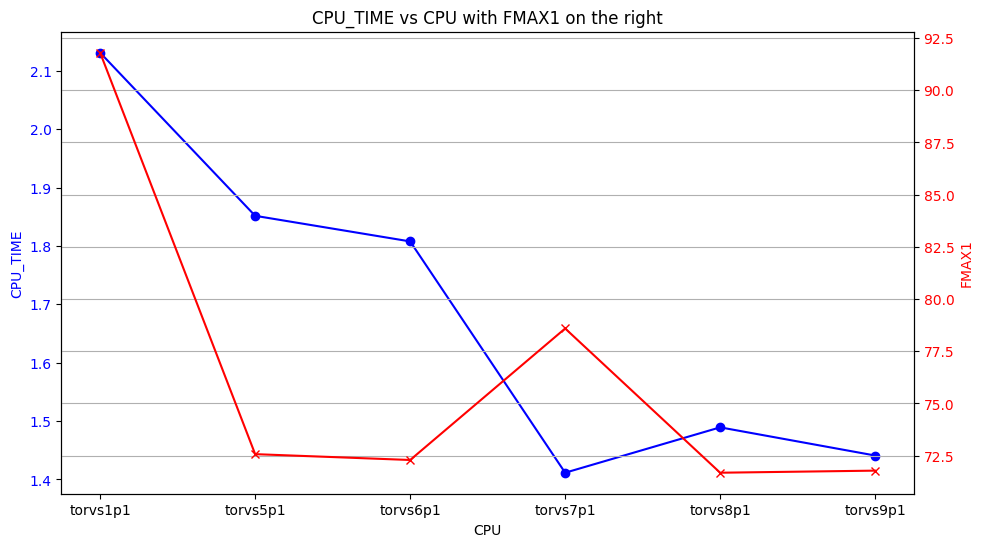

In [68]:
plot_graph_pareto(0,"p1")
plot_graph_time(0,"p1", df2)
plot_graph_cpi(0, "p1", df2)
plot_graph_fmax(0, "p1", df2)

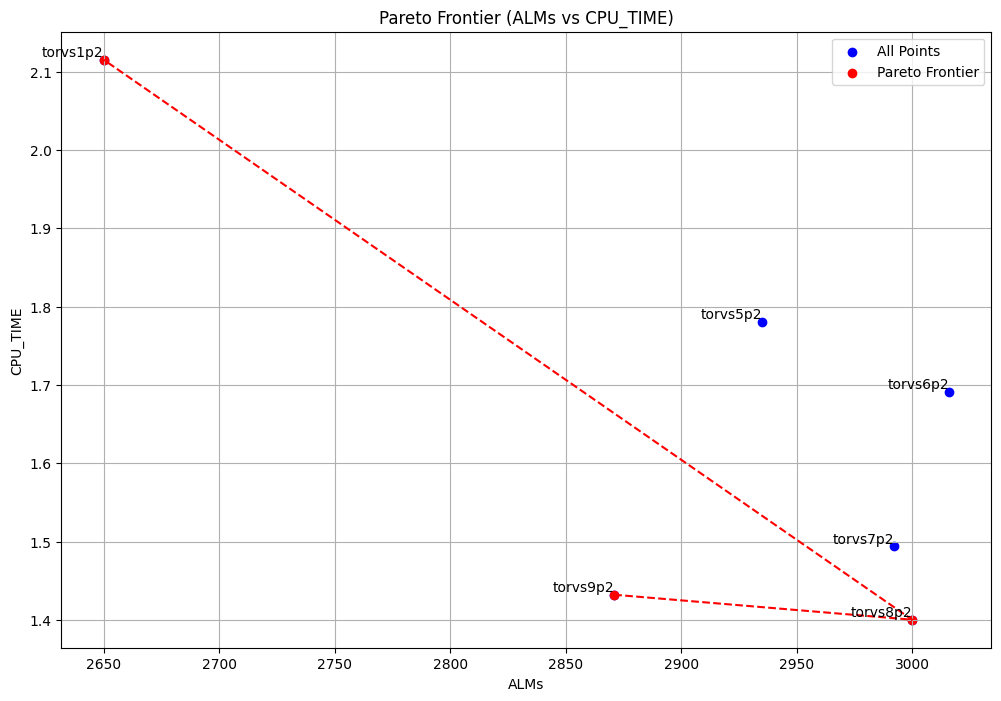

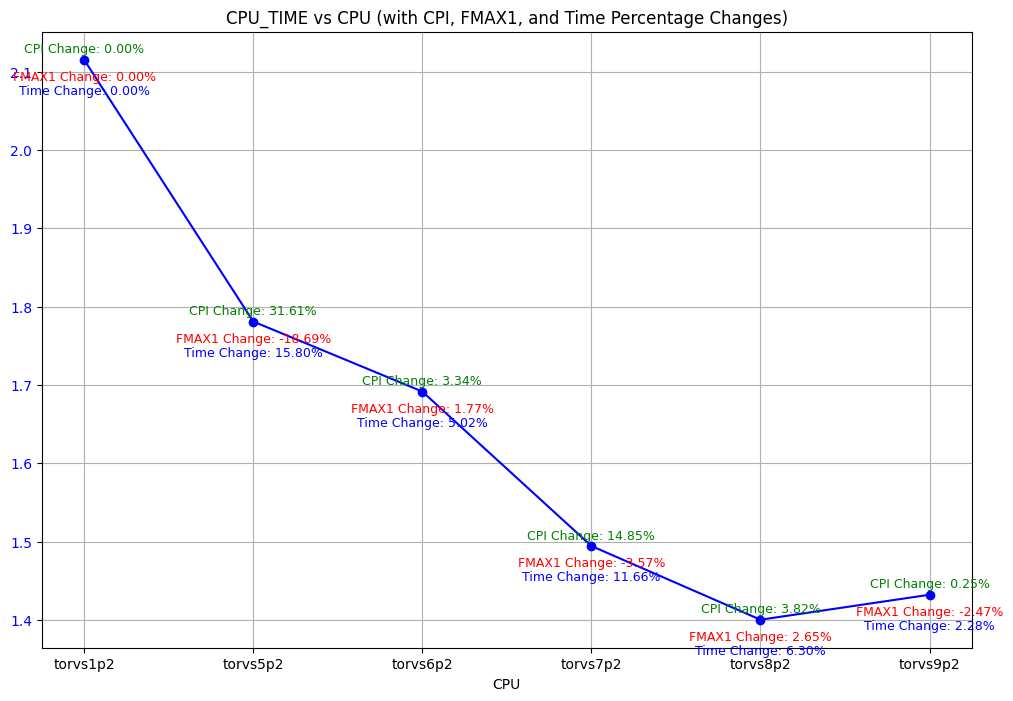

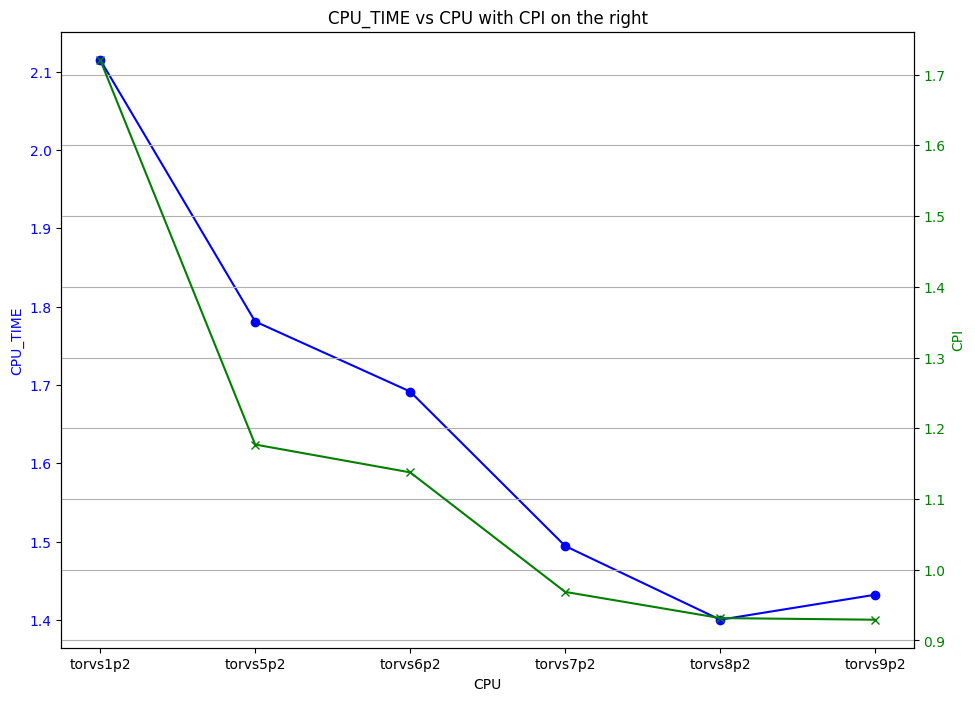

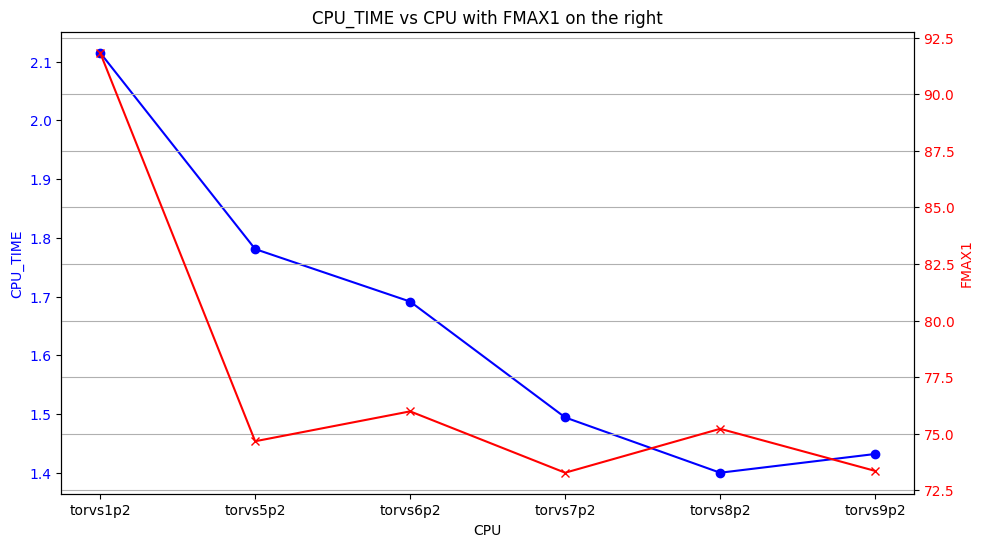

In [69]:
plot_graph_pareto(0,"p2")
plot_graph_time(0,"p2", df2)
plot_graph_cpi(0, "p2", df2)
plot_graph_fmax(0, "p2", df2)

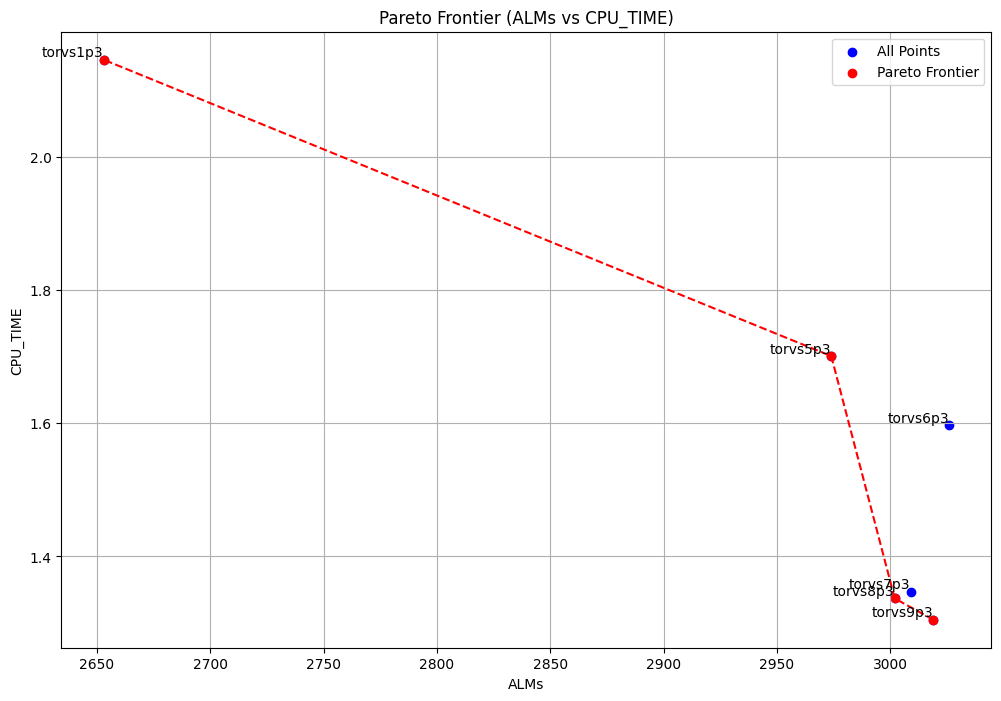

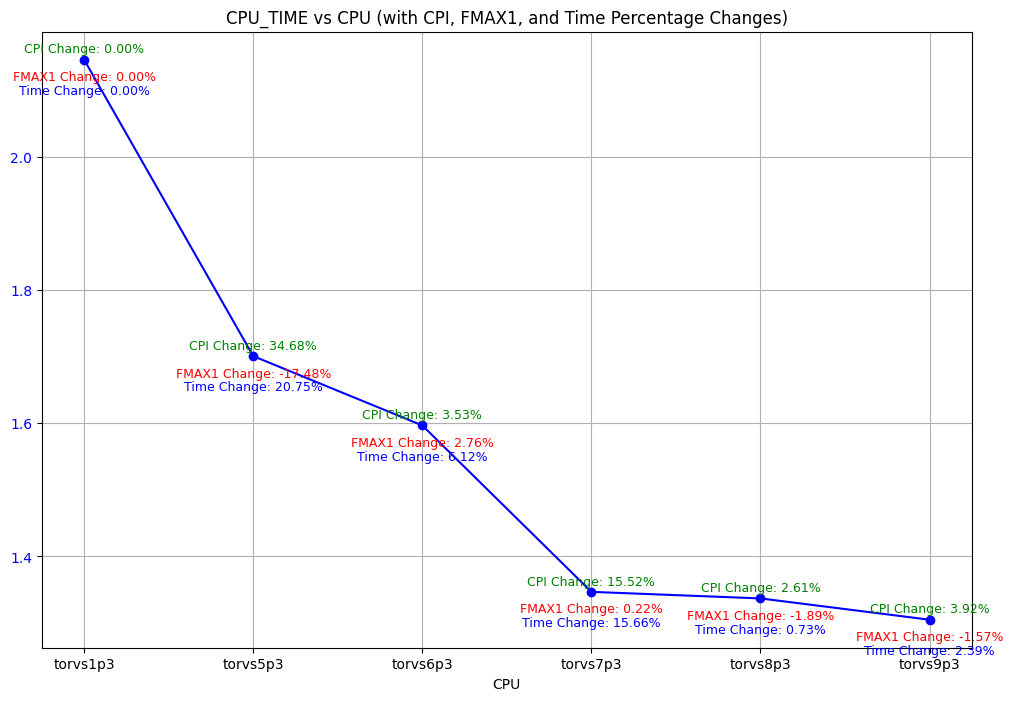

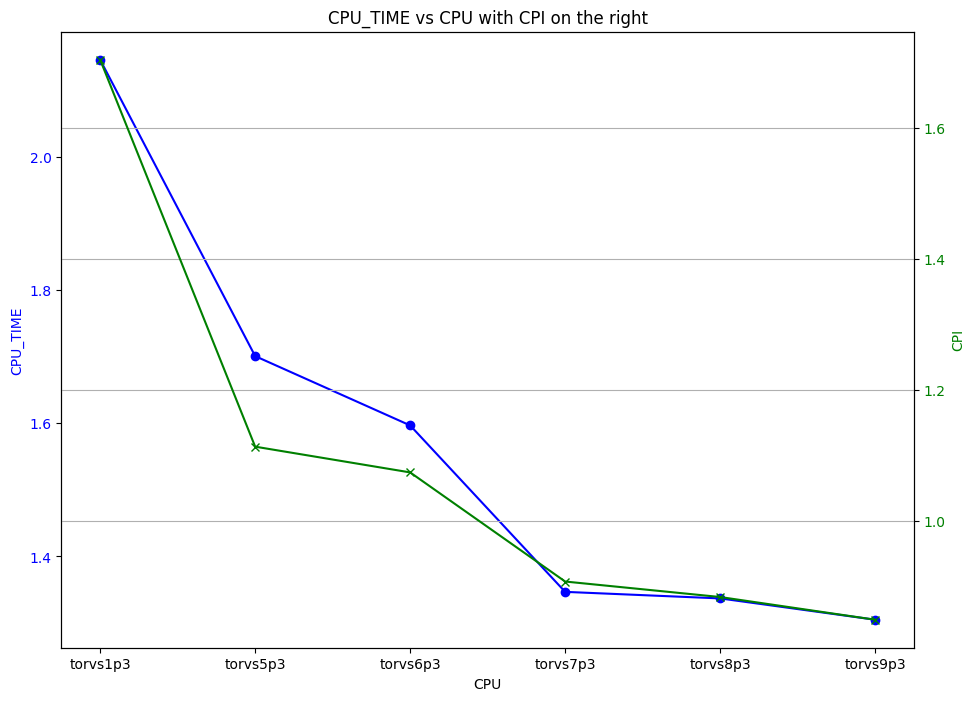

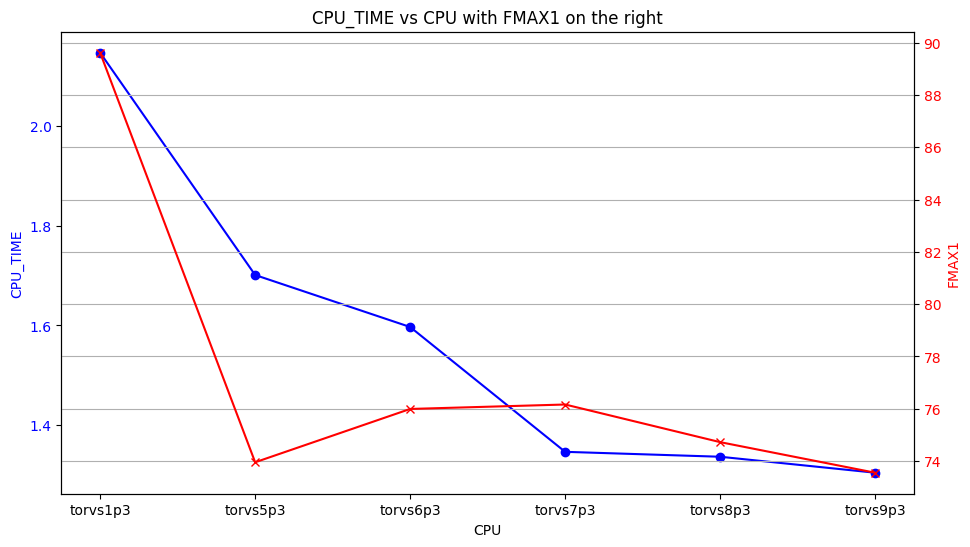

In [70]:
plot_graph_pareto(0,"p3")
plot_graph_time(0,"p3", df2)
plot_graph_cpi(0, "p3", df2)
plot_graph_fmax(0, "p3", df2)

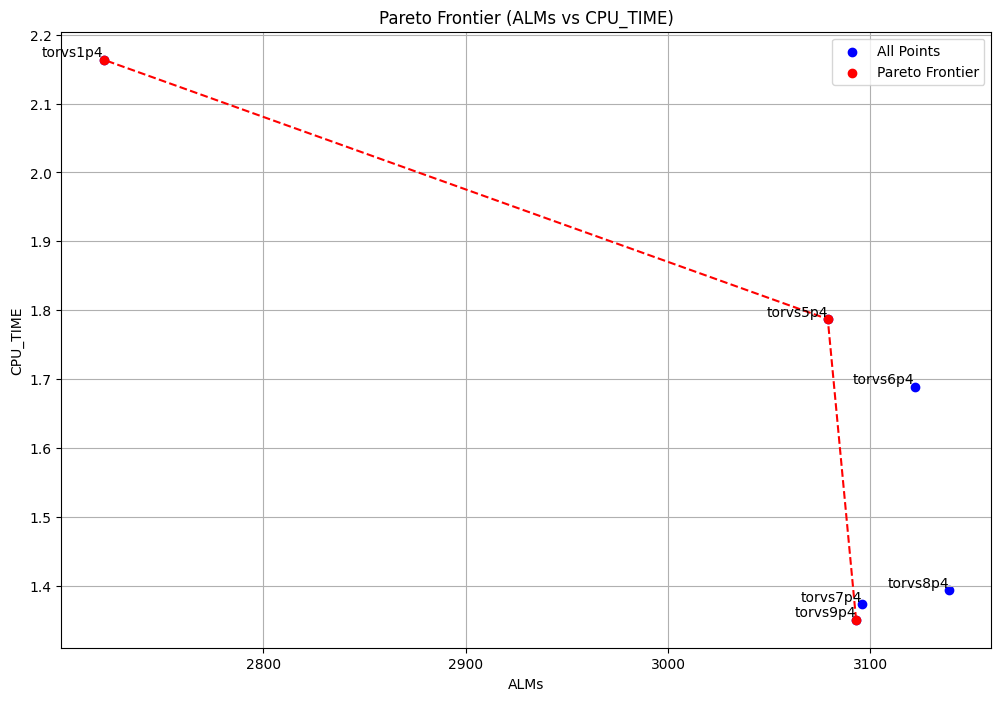

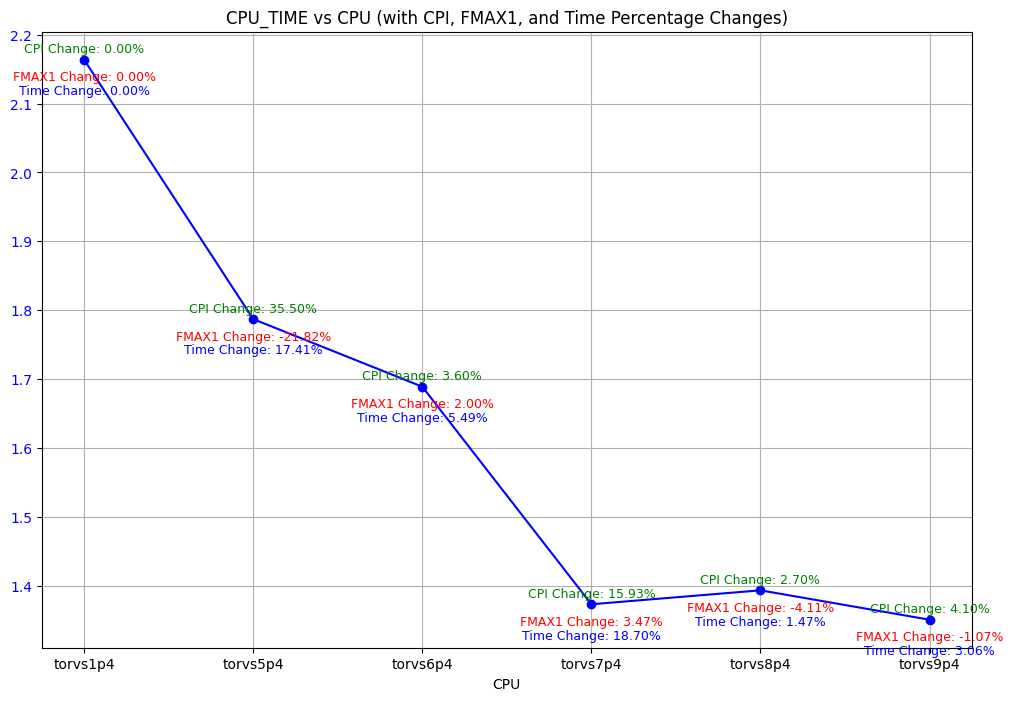

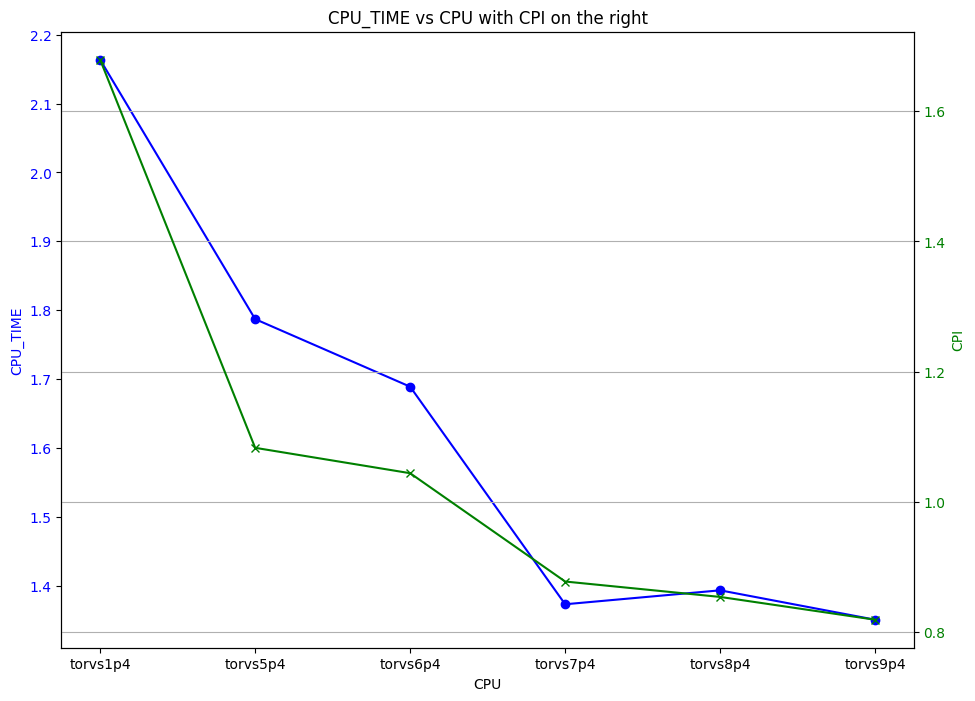

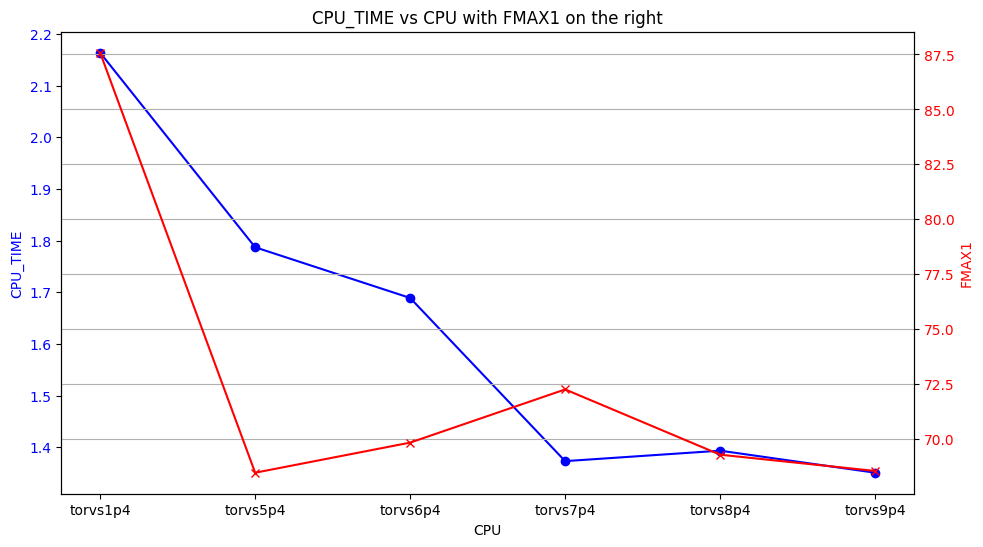

In [71]:
plot_graph_pareto(0,"p4")
plot_graph_time(0,"p4", df2)
plot_graph_cpi(0, "p4", df2)
plot_graph_fmax(0, "p4", df2)

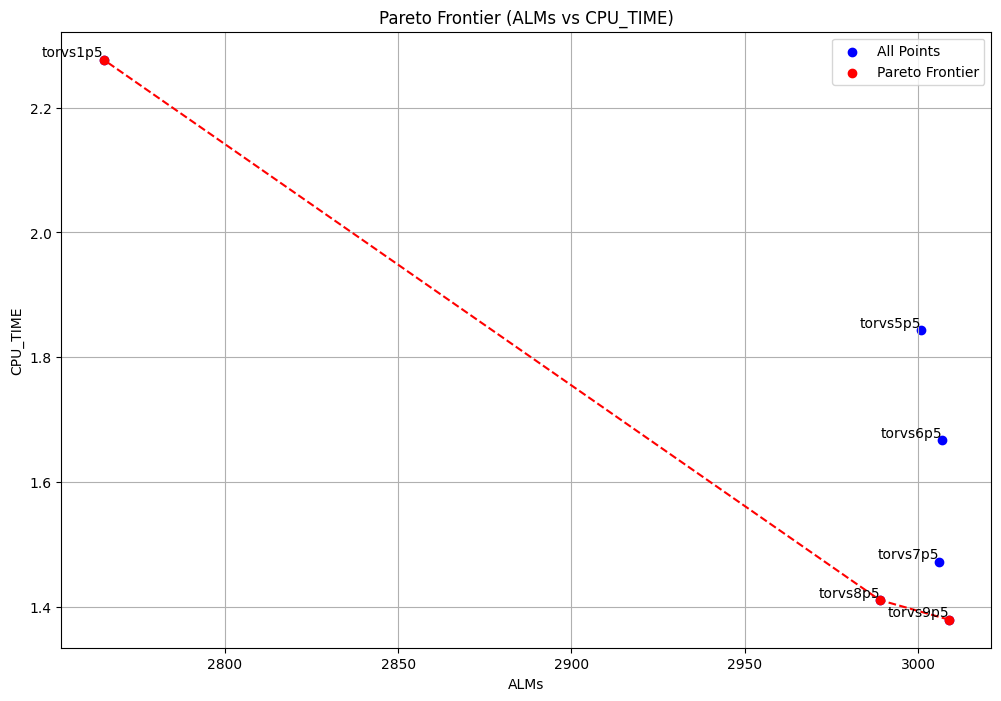

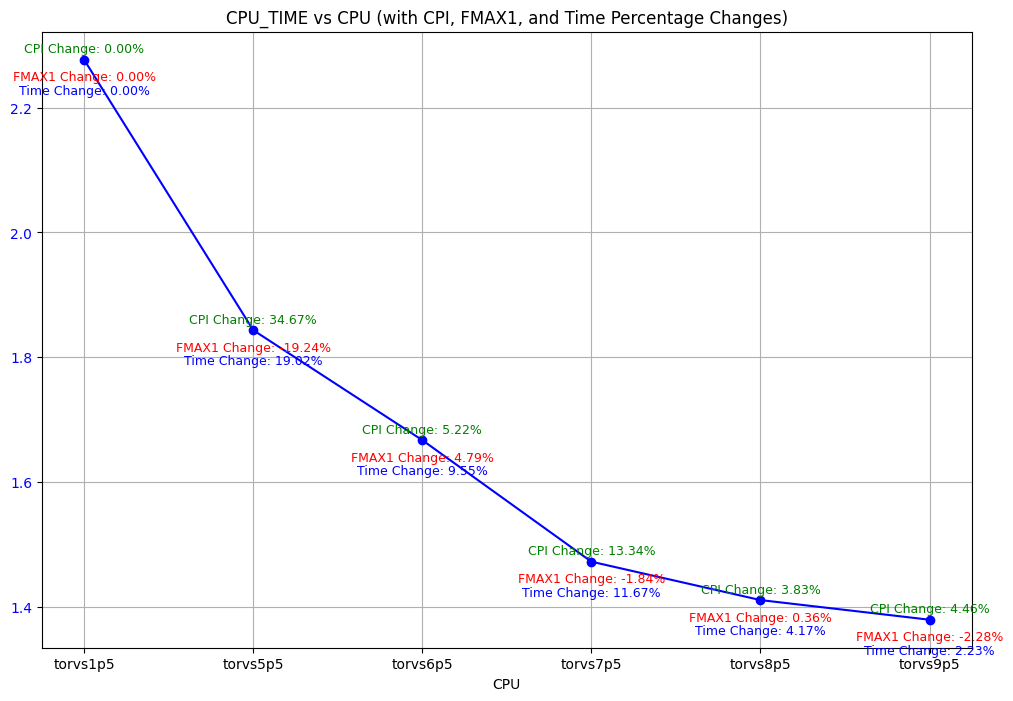

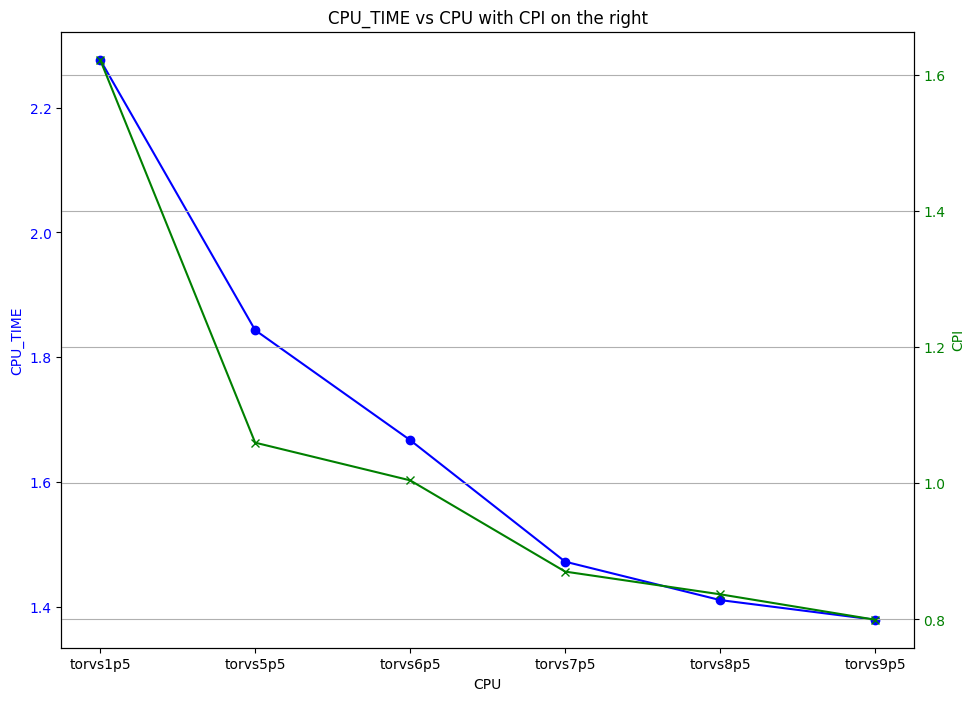

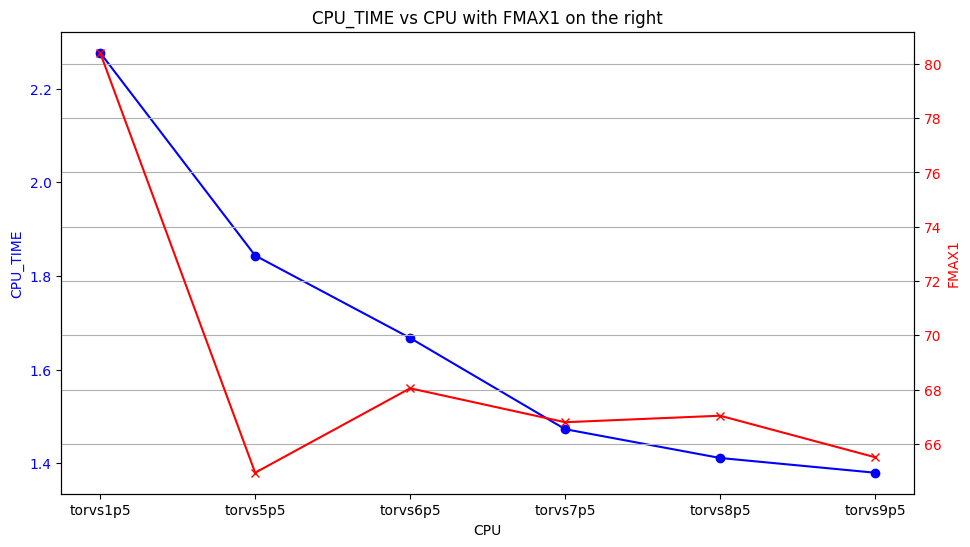

In [72]:
plot_graph_pareto(0,"p5")
plot_graph_time(0,"p5", df2)
plot_graph_cpi(0, "p5", df2)
plot_graph_fmax(0, "p5", df2)

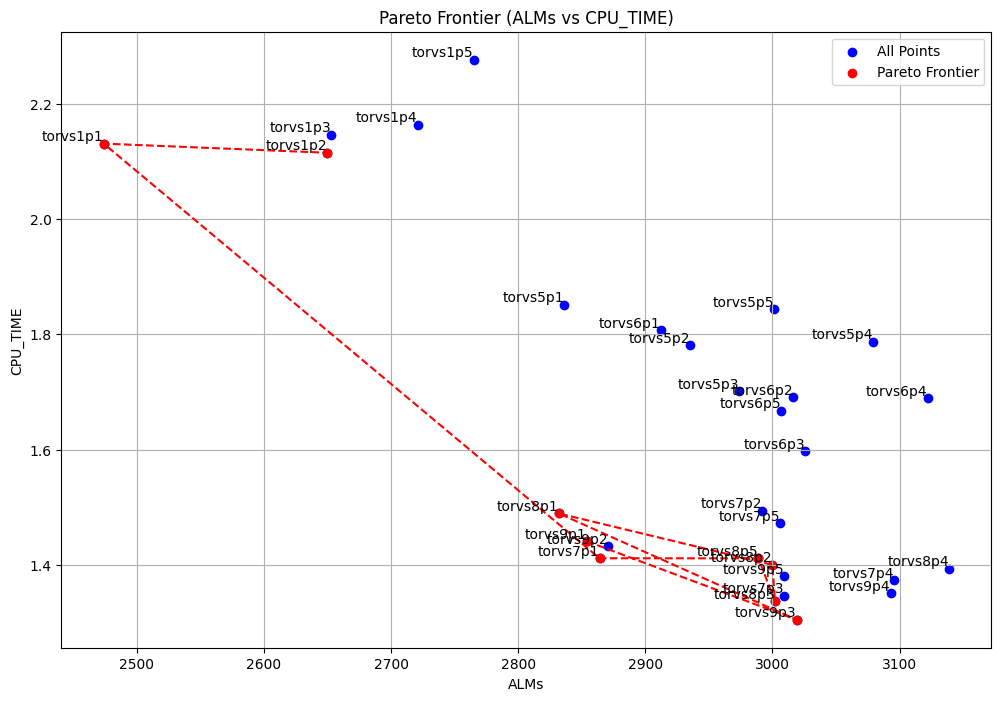

In [73]:
plot_graph_pareto(1,"torvs")